In [1]:
# setup the P4P client
# https://mdavidsaver.github.io/p4p/client.html#usage
import numpy as np
import time
import matplotlib.pyplot as plt
from p4p.client.thread import Context
print( Context.providers() )
ctxt = Context('pva')

# Some useful pointers to reduce string lengths
Root = 'kek_bpm_rfsoc_demo_ioc:Root'
AxiVersion  = f'{Root}:RFSoC:AxiSocCore:AxiVersion'
ReadoutCtrl = f'{Root}:RFSoC:Application:ReadoutCtrl'
AdcDispProcessor  = [ f'{Root}:AdcDispProcessor[{i}]'  for i in range(4)]
AmpDispProcessor  = [ f'{Root}:AmpDispProcessor[{i}]'  for i in range(4)]
AmpFaultProcessor = [ f'{Root}:AmpFaultProcessor[{i}]' for i in range(4)]

# Function to trigger the waveform ring buffers
def TrigRingBuffer(trigType='liveDisplay'):

    if trigType=='liveDisplay':
        for i in range(4):
            ctxt.put(  f'{AdcDispProcessor[i]}:RxEnable', 1)
            ctxt.put(  f'{AmpDispProcessor[i]}:RxEnable', 1)             
            ctxt.put(  f'{AdcDispProcessor[i]}:Updated', 0)
            ctxt.put(  f'{AmpDispProcessor[i]}:Updated', 0)        
        ctxt.put( f'{ReadoutCtrl}:LiveDispTrigRaw', 1)
        #ctxt.rpc( f'{ReadoutCtrl}:LiveDispTrig')
        for i in range(4):
            # Wait for Waveform
            while ( ctxt.get( f'{AdcDispProcessor[i]}:Updated') != True):
                time.sleep(0.01)
            while ( ctxt.get( f'{AmpDispProcessor[i]}:Updated') != True):
                time.sleep(0.01)                
    
    elif trigType=='faultDisplay':
        for i in range(4):
            ctxt.put(  f'{AmpFaultProcessor[i]}:RxEnable', 1)               
            ctxt.put(  f'{AmpFaultProcessor[i]}:Updated', 0)         
        ctxt.put( f'{ReadoutCtrl}:SwFaultTrigRaw', 1)
        # ctxt.rpc( f'{ReadoutCtrl}:SwFaultTrig')
        for i in range(4):
            # Wait for Waveform
            while ( ctxt.get( f'{AmpFaultProcessor[i]}:Updated') != True):
                time.sleep(0.01)  
    
    else:
        print('Error: TrigRingBuffer.trigType={trigType} is not supported')

# Function to plot the ADC/DAC waveforms
def PlotWavform(plotType='liveDisplay',dataType='Amp',ch=0,xMin=0,xMax=20):

    if plotType=='liveDisplay':
        if dataType=='Adc':
            xData = ctxt.get(f'{AdcDispProcessor[ch]}:Time')
            yData = ctxt.get(f'{AdcDispProcessor[ch]}:WaveformData')
        else:
            xData = ctxt.get(f'{AmpDispProcessor[ch]}:Time')
            yData = ctxt.get(f'{AmpDispProcessor[ch]}:WaveformData')               
    
    elif plotType=='faultDisplay':
        xData = ctxt.get(f'{AmpFaultProcessor[ch]}:Time')
        yData = ctxt.get(f'{AmpFaultProcessor[ch]}:WaveformData')            
    else:
        print('Error: PlotWavform.plotType={trigType} is not supported')

    plt.plot(xData,yData)
    plt.xlim(xMin,xMax)
    plt.xlabel( 'Time (ns)' )
    plt.ylabel( f'{dataType}[ch={ch}] (Counts)' )
    plt.show()

['pva']


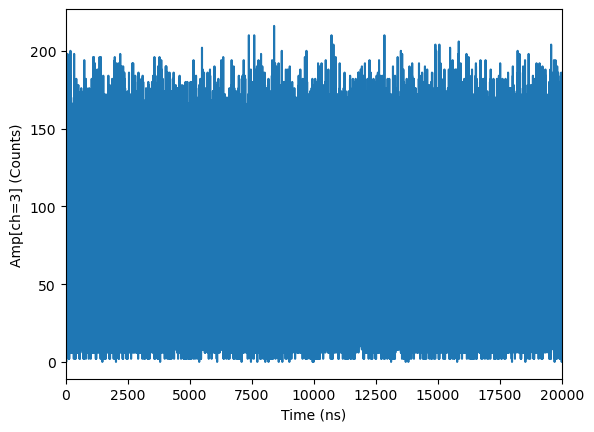

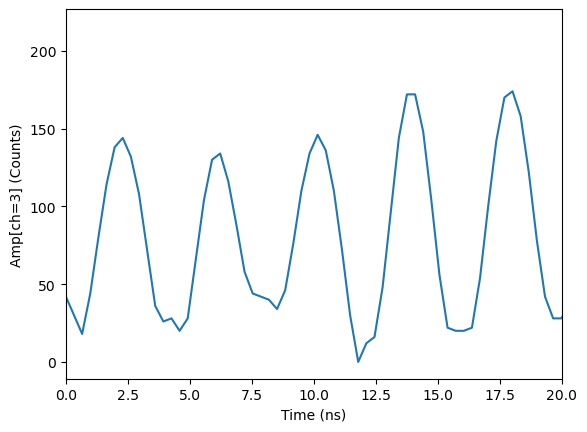

In [3]:
# Trigger the Fault display
TrigRingBuffer(trigType='faultDisplay')

# Plot ADC[CH=2] for 20 us
PlotWavform(plotType='faultDisplay',dataType='Amp',ch=3, xMin=0, xMax=20.0E+3)

# Plot ADC[CH=2] for 20 ns
PlotWavform(plotType='faultDisplay',dataType='Amp',ch=3, xMin=0, xMax=20)

In [11]:
def peak_search(waveform,start_index):
    mountain_maxima = []
    points_per_bunch = 12
    for i in range(start_index, len(waveform)-points_per_bunch+start_index, points_per_bunch):
        peak = max(waveform[i:i+points_per_bunch])
        if peak >= 250:
            mountain_maxima.append(peak)
        #else:
         #   mountain_maxima.append(0)
    return np.array(mountain_maxima)

In [6]:
"""
amp_dict_0={}
peak_dict_0={}
amp_dict_1={}
peak_dict_1={}
amp_dict_2={}
peak_dict_2={}
amp_dict_3={}
peak_dict_3={}
"""

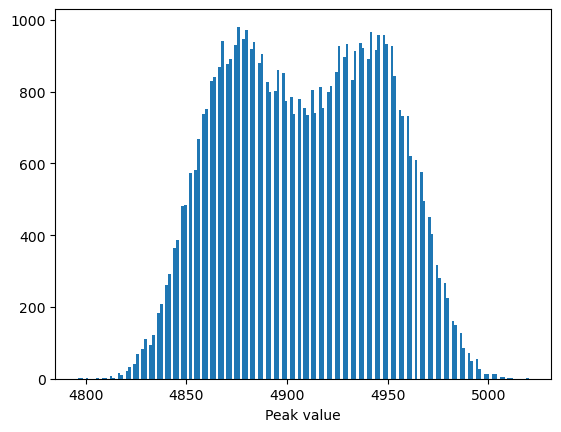

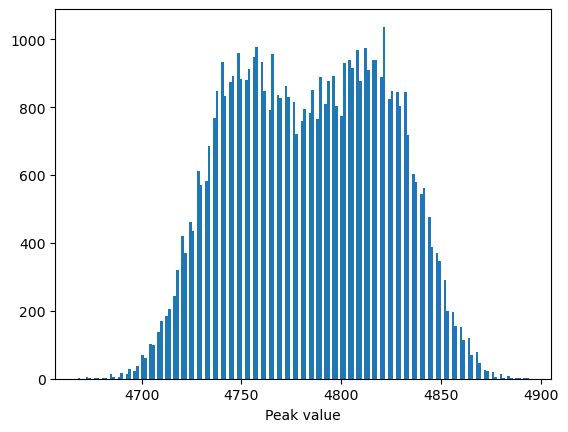

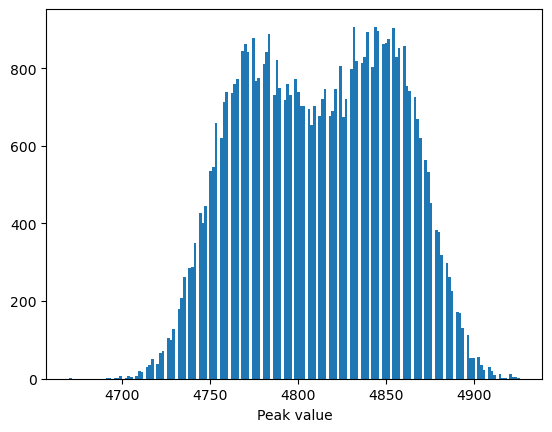

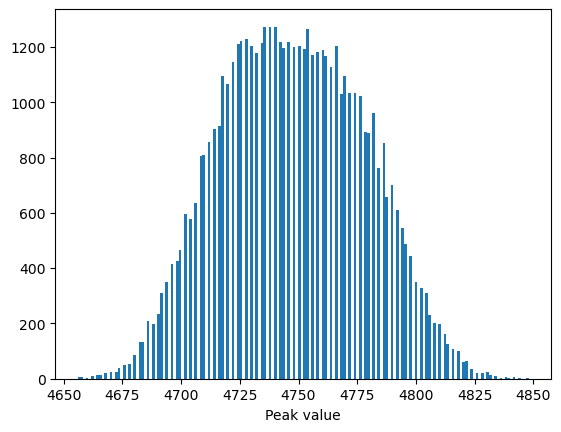

In [71]:
string='32000'
amp_0=[]
amp_1=[]
amp_2=[]
amp_3=[]
peak_0=[]
peak_1=[]
peak_2=[]
peak_3=[]
for i in range(10):
    TrigRingBuffer(trigType='faultDisplay')
    wave_0=ctxt.get(f'{AmpFaultProcessor[0]}:WaveformData')
    wave_1=ctxt.get(f'{AmpFaultProcessor[1]}:WaveformData')
    wave_2=ctxt.get(f'{AmpFaultProcessor[2]}:WaveformData')
    wave_3=ctxt.get(f'{AmpFaultProcessor[3]}:WaveformData')
    peak_0.append(peak_search(wave_0,np.argmin(wave_0[:12])))
    peak_1.append(peak_search(wave_1,np.argmin(wave_1[:12])))
    peak_2.append(peak_search(wave_2,np.argmin(wave_2[:12])))
    peak_3.append(peak_search(wave_3,np.argmin(wave_3[:12])))
    if i < 5:
        amp_0.append(wave_0)
        amp_1.append(wave_1)
        amp_2.append(wave_2)
        amp_3.append(wave_3)
    time.sleep(1)


amp_dict_0[string]=amp_0
amp_dict_1[string]=amp_1
amp_dict_2[string]=amp_2
amp_dict_3[string]=amp_3
peak_dict_0[string]=peak_0
peak_dict_1[string]=peak_1
peak_dict_2[string]=peak_2
peak_dict_3[string]=peak_3

plt.hist(np.concatenate(peak_0),bins=170)
plt.xlabel('Peak value')
plt.show()
plt.hist(np.concatenate(peak_1),bins=170)
plt.xlabel('Peak value')
plt.show()
plt.hist(np.concatenate(peak_2),bins=170)
plt.xlabel('Peak value')
plt.show()
plt.hist(np.concatenate(peak_3),bins=170)
plt.xlabel('Peak value')
plt.show()

In [72]:
amp_dict_0['28000']

[ntndarray([1710, 2908, 3860, ..., 2838, 3810, 4286], dtype=int16),
 ntndarray([4136, 3366, 2222, ..., 3424, 2302, 1098], dtype=int16),
 ntndarray([4136, 3366, 2222, ..., 3424, 2302, 1098], dtype=int16),
 ntndarray([1686, 2888, 3840, ..., 2814, 3790, 4274], dtype=int16),
 ntndarray([326, 498, 320, ..., 484, 360, 550], dtype=int16)]

In [73]:
result_peak=[]
result_peak.append(peak_dict_0)
result_peak.append(peak_dict_1)
result_peak.append(peak_dict_2)
result_peak.append(peak_dict_3)
result_amp=[]
result_amp.append(amp_dict_0)
result_amp.append(amp_dict_1)
result_amp.append(amp_dict_2)
result_amp.append(amp_dict_3)

In [74]:
import pickle

with open('../data/Peakdata_1GHz_3054MSPS.pkl','wb') as file:
    pickle.dump(result_peak, file)

with open('../data/Ampdata_1GHz_3054MSPS.pkl','wb') as file:
    pickle.dump(result_amp, file)